In [67]:
import numpy as np
import pandas as pd
from IPython.display import display
import re
from gensim.parsing.preprocessing import strip_short, remove_stopwords, strip_non_alphanum, strip_numeric, strip_multiple_whitespaces, strip_punctuation, strip_tags

# Training and Test data - Preprocessing & Vectorization

In [68]:
df = pd.read_csv('./data/auto_tweets.csv')

In [69]:
def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = strip_tags(text)
    text = strip_non_alphanum(text)
    text = strip_punctuation(text)
    text = strip_numeric(text)
    text = text.lower()
    text = strip_multiple_whitespaces(text)
    
    return text

In [70]:
df['text'] = df['text'].apply(text_preprocessing)

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

In [72]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['text']) 

# Validation data - Preprocessing & Vectorization

In [73]:
def sentiment_mapper(sentiment):
    if sentiment == 'negative':
        return -1
    if sentiment == 'neutral':
        return 0
    if sentiment == 'positive':
        return 1

df2 = pd.read_csv('./data/airline_tweets.csv')
df2 = df2[['airline_sentiment','text']]
df2['text'] = df2['text'].apply(text_preprocessing) 
df2['airline_sentiment'] = df2['airline_sentiment'].apply(sentiment_mapper)

X_eval = cv.transform(df2['text'])
y_eval = df2['airline_sentiment']

# Training model

In [55]:
from sklearn.model_selection import train_test_split

In [74]:
train_size = 0.0625
test_size = 0.00625
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['auto_sentiment'], stratify = df['auto_sentiment'], train_size = train_size, test_size = test_size, random_state = 5)

In [75]:
display(X_train.shape)
display(X_test.shape)

(100000, 310949)

(10000, 310949)

In [76]:
import pickle
import os
from sklearn.naive_bayes import MultinomialNB
read = False
should_pickle = True
filename = "model.pkl"

if not read:
    model = MultinomialNB()
    model.fit(X_train, y_train)
    if should_pickle:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
else:
    with open(filename, 'rb') as file:
        pickle_model = pickle.load(filename)


# Results

In [77]:
from sklearn import metrics

# Test Results

In [78]:
predicted = model.predict(X_test)
accuracy = metrics.accuracy_score(predicted, y_test)
fscore = metrics.precision_recall_fscore_support(y_test, predicted, average='weighted')

In [79]:
display(accuracy)
display(fscore)

0.5965

(0.7145588460028677, 0.5965, 0.5226194573999978, None)

# Evaluation Results

In [80]:
predicted = model.predict(X_eval)
accuracy = metrics.accuracy_score(predicted, y_eval)
fscore = metrics.precision_recall_fscore_support(y_eval, predicted, average='weighted')

In [81]:
display(accuracy)
display(fscore)

0.30628415300546447

(0.6841619254361557, 0.30628415300546447, 0.29042245668274624, None)

# Naive Bayes with eval data only

In [86]:
df2.head(1)

,airline_sentiment,text
0,0,what said


In [89]:
air_token = RegexpTokenizer(r'[a-zA-Z0-9]+')
air_cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = air_token.tokenize)
air_text_counts = air_cv.fit_transform(df2['text']) 

In [91]:
train_size = 0.7
test_size = 0.3
air_X_train, air_X_test, air_y_train, air_y_test = train_test_split(air_text_counts, df2['airline_sentiment'], stratify = df2['airline_sentiment'], train_size = train_size, test_size = test_size, random_state = 5)

In [92]:
air_model = MultinomialNB()
air_model.fit(air_X_train, air_y_train)

MultinomialNB()

In [95]:
air_predicted = air_model.predict(air_X_test)
air_accuracy = metrics.accuracy_score(air_predicted, air_y_test)
air_fscore = metrics.precision_recall_fscore_support(air_y_test, air_predicted, average='weighted')

In [96]:
display(air_accuracy)

0.7484061930783242

In [97]:
display(air_fscore)

(0.733920149212842, 0.7484061930783242, 0.7242806127126318, None)

# Plots

In [82]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

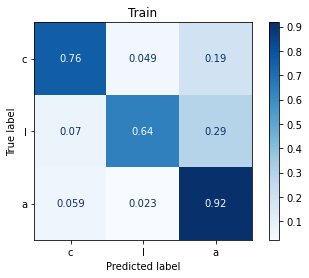

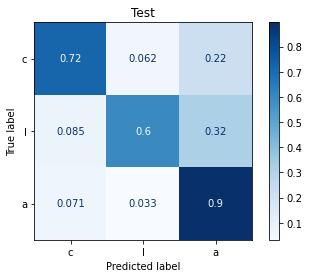

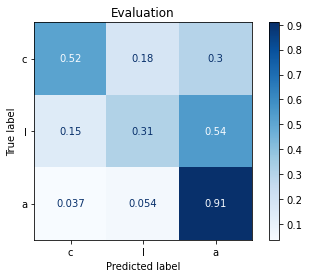

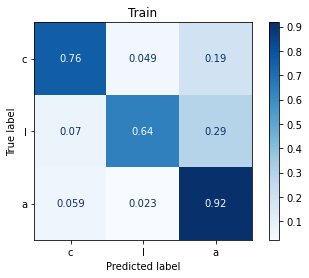

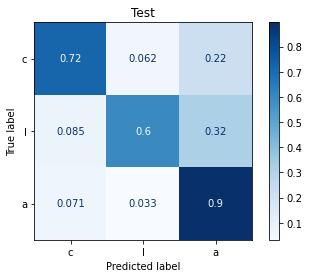

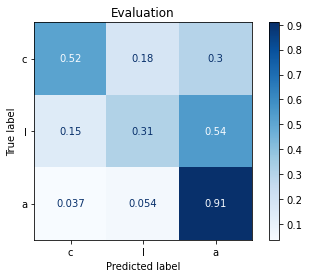

In [66]:
Xs = [X_train, X_test, X_eval]
Ys = [y_train, y_test, y_eval]
names = ['Train', 'Test', 'Evaluation']

save_img = False

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    for X, y, name in zip(Xs, Ys, names):
        disp = plot_confusion_matrix(model, X, y,
                                     display_labels="class_names",
                                     cmap=plt.cm.Blues,
                                     normalize='true',
                                    )
        disp.ax_.set_title(name)
        if save_img:
            plt.savefig('{}.png'.format(name))